# Custom Callbacks

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

print("Version: ", tf.__version__)
tf.get_logger().setLevel('INFO')

Version:  2.2.0


In [3]:
def get_model():
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation='linear', input_dim=784)
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mse', metrics=['mae'])
    
    return model

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

In [5]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        print(f'Training batch {batch} begins at {datetime.datetime.now().time()}')
        
    def on_train_batch_end(self, batch, logs=None):
        print(f'Training: Batch {batch} ends at {datetime.datetime.now().time()}')

In [6]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training batch 0 begins at 15:00:06.945056
Training: Batch 0 ends at 15:00:07.301903
Training batch 1 begins at 15:00:07.302196
Training: Batch 1 ends at 15:00:07.303181
Training batch 2 begins at 15:00:07.303421
Training: Batch 2 ends at 15:00:07.304075
Training batch 3 begins at 15:00:07.304212
Training: Batch 3 ends at 15:00:07.305000
Training batch 4 begins at 15:00:07.305226
Training: Batch 4 ends at 15:00:07.305931


## Usage of `logs` dict

In [7]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs:
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 0.46
Epoch: 1, Val/Train loss ratio: 0.56
Epoch: 2, Val/Train loss ratio: 2.28


In [9]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.7):
        super(DetectOverfittingCallback, self).__init__()
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs=None):
        ratio = logs["val_loss"] / logs['loss']
        print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))
        
        if(ratio > self.threshold):
            print("Stopping training...")
            self.model.stop_training = True
            
model = get_model()
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=10,
    verbose=0,
    callbacks=[DetectOverfittingCallback()]
)

Epoch: 0, Val/Train loss ratio: 0.83
Stopping training...


## Custom Callbacks to Visualize Predictions

In [10]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [11]:
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    plt.clf()
    
    plt.yticks([])
    plt.grid(None)
    
    inputs = np.reshape(inputs, [n, 28, 28])
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    
    plt.imshow(inputs)
    plt.xticks([28*x + 14 for x in range(n)], outputs)
    
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if(outputs[i] == ground_truth[i]):
            t.set_color('green')
        else:
            t.set_color('red')
            
    plt.grid(None)

In [12]:
GIF_PATH = './animation.gif'

In [13]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        self.inputs = inputs
        self.ground_truth = ground_truth
        self.images = []
        self.display_freq = display_freq
        self.n_samples = n_samples
        
    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)
        
        
        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.display_freq)
        
        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))
        
        # Display the digits every `display_freq` number of epochs
        if(epoch % self.display_freq == 0):
            plt.show()
            
    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [14]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

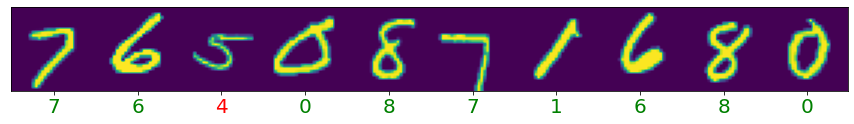

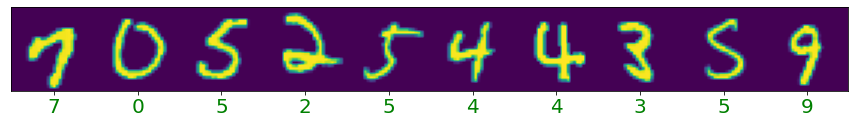

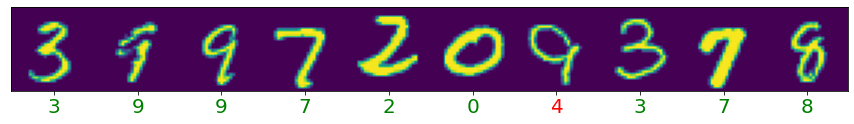

In [15]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

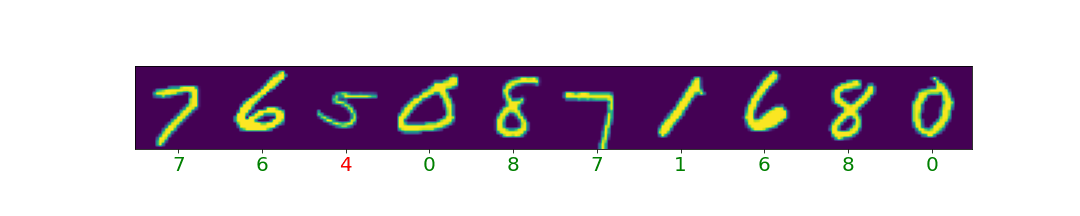

In [16]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE) 